In [27]:
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split


In [2]:
WINDOW_MA = 10
WINDOW_RSI = 10
SLIDING_WINDOW = 5
EPSILON_TOLERANCE = 0.15
TRAINING_PCT = 0.8

Lectura de archivos

In [37]:
tweets_df = pd.read_csv("../data/tweets_with_sentiment_cryptobert.csv")
price_df = pd.read_csv("../data/data_binance.csv")

In [38]:

tweets_df['fecha'] = pd.to_datetime(tweets_df['Created At'], errors='coerce')

# Asigna dia, mes y año a la nueva columna fecha quitando la hora
tweets_df['fecha'] = tweets_df['fecha'].dt.date
price_df['fecha'] = pd.to_datetime(price_df['fecha'], errors='coerce')
tweets_df.head(5)


,Username,Text,Created At,Retweets,Likes,Sentiment,fecha
0,Peter McCormack 🏴‍☠️🇬🇧🇮🇪,Happy New Year to you all.\n\nI hope you all h...,2023-01-01 01:49:27+00:00,8.0,450.0,1,2023-01-01
1,Mohamed A. El-Erian,The notion of an exciting football game means ...,2023-01-01 01:55:27+00:00,3.0,419.0,1,2023-01-01
2,Jimmy Song (송재준),"10 years ago, I:\n\n* Bought more Bitcoin\n* S...",2023-01-01 06:48:00+00:00,21.0,531.0,1,2023-01-01
3,Jameson Lopp,Bitcoin average DAILY value change during:\n20...,2023-01-01 12:50:57+00:00,35.0,231.0,0,2023-01-01
4,Jameson Lopp,Bitcoin average DAILY value change during:\n20...,2023-01-01 12:50:57+00:00,35.0,231.0,0,2023-01-01


In [39]:
# We count by kind of feeling
count_sentiment = tweets_df.groupby(['fecha', 'Sentiment']).size().unstack(fill_value=0)

# We recalculate totals and average
count_sentiment['numero_noticias'] = count_sentiment.sum(axis=1)
count_sentiment['promedio_sentimiento'] = tweets_df.groupby('fecha')['Sentiment'].mean()

Transforma las columnas date en formato datetime.date

In [40]:
price_df['fecha'] = pd.to_datetime(price_df['fecha']).dt.date 
count_sentiment = count_sentiment.reset_index()  # si 'fecha' está en el índice
count_sentiment['fecha'] = pd.to_datetime(count_sentiment['fecha']).dt.date
count_sentiment.rename(
    columns={
        -1:'negative_sentiment_news',
        0:'neutral_sentiment_news',
        1:'positive_sentiment_news'
    },
    inplace=True
)


Realiza la fusión de los dos DataFrames (price_df y conteo_sentimientos) usando la columna fecha como clave



In [41]:
# We join by date
df_final = price_df.merge(count_sentiment, on='fecha', how='left')

CALCULO MEDIA MOVIL CON DERIVADA Y TENDENCIA

In [42]:

# We added trend column
df_final['media_movil_10d'] = df_final['precio_apertura'].rolling(WINDOW_MA).mean()

# PROFE TIPS: la derivada hecha con la funcion diff no es la mejor opcion
# revisar otras funciones de derivadas

# LISTO CORREGIDO
df_final['mm10_smooth'] = savgol_filter(df_final['media_movil_10d'], WINDOW_MA+1, polyorder=2)
df_final['derivada_mm10'] = np.gradient(df_final['mm10_smooth'])



In [43]:
epsilon = df_final['derivada_mm10'].std() * EPSILON_TOLERANCE
condition_list = [
    df_final['derivada_mm10'].isna() | ((df_final['derivada_mm10'] > -epsilon) & (df_final['derivada_mm10'] < epsilon)),
    df_final['derivada_mm10'] > 0,
    df_final['derivada_mm10'] < 0,
]
returns_values_list = [0, 1, -1]
df_final['tendencia_categorizada'] = np.select(condition_list, returns_values_list, 0)

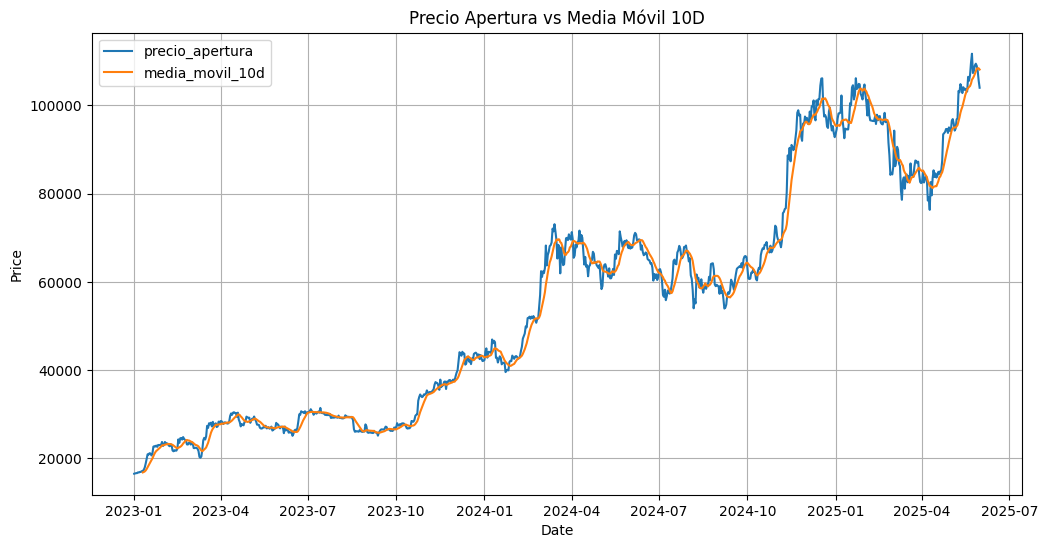

In [47]:
# Grafico precio apertura vs media movil 10d
df_temp = df_final.copy()
df_temp.set_index('fecha', inplace=True)
df_temp[['precio_apertura', 'media_movil_10d']].plot(figsize=(12,6), title='Precio Apertura vs Media Móvil 10D', grid=True)
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()


📈 Indicador RSI (Relative Strength Index)

📊 RSI toma valores entre 0 y 100:

- (<30) podría indicar sobreventa.
- (>70) podría indicar sobrecompra.

In [ ]:
# PROFE TIPS: trata de no usar funciones creadas por ti para los indicadores
# LISTO CORREGIDO

df_final['RSI_10'] = talib.RSI(df_final['precio_apertura'], WINDOW_RSI)

🔁 Indicador MACD (Moving Average Convergence Divergence)


In [ ]:
# EMA rápida y lenta
ema_12 = df_final['precio_apertura'].ewm(span=12, adjust=False).mean()
ema_26 = df_final['precio_apertura'].ewm(span=26, adjust=False).mean()

# Línea MACD y señal
df_final['MACD'] = ema_12 - ema_26
df_final['MACD_signal'] = df_final['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
df_final

Creación df con indicadores finales

In [ ]:
# Selecting final columns
df_csv = df_final[['fecha',
                    'precio_apertura',
                    'media_movil_10d', 
                    'RSI_10', 
                    'MACD_signal', 
                    'tendencia_categorizada', 
                    'numero_noticias', 
                    'negative_sentiment_news', 
                    'neutral_sentiment_news', 
                    'positive_sentiment_news', 
                    'promedio_sentimiento']]

# We rename columns
df_csv.columns = ['date', 
                  'open',
                  'MA',
                  'RSI',
                  'MACD', 
                  'trend', 
                  'issue_news', 
                  'negative_sentiment_news', 
                  'neutral_sentiment_news', 
                  'positive_sentiment_news', 
                  'average_news']



In [ ]:
df_final.head(5)

In [ ]:
df_csv.head(5)

Creación ventana deslizante

In [ ]:
# Features
colums_windows = ['open','MA','RSI','MACD', 'trend', 'issue_news', 
                    'negative_sentiment_news', 'neutral_sentiment_news', 'positive_sentiment_news', 'average_news']

# Lista para almacenar las wind
wind = []

# Recorremos desde el día 1 hasta len (cantidad de filas del df) - ventana 
for i in range(len(df_csv) - SLIDING_WINDOW):
    # Extraemos las filas de la ventana anterior (días pasados)
    segment = df_csv[colums_windows].iloc[i:i+SLIDING_WINDOW]
    
    # Aplanamos los datos de la ventana en una sola fila
    row_wind = segment.values.flatten()

    date = df_csv['date'].iloc[i-1 + SLIDING_WINDOW]
    #Precio objetivo: el siguiente día después de la ventana
    target_trend = df_csv['trend'].iloc[i + SLIDING_WINDOW]

    # Se crea la fila con target_date, target_trend y la ventana
    wind.append([date] + row_wind.tolist() + [target_trend])
    
columns_name = ['date']
# Generacion de columnas "open_d1, RS1_d1, open_d2, etc" de la ventana deslizante


x = (np.arange(SLIDING_WINDOW) * -1)[::-1]
for i, day in enumerate(x) :
    for col in colums_windows:
        columns_name.append(f'{col}_d{day}')
# Se crea la columna de target
columns_name.append('target_trend')



Exportar csv

In [ ]:
# DataFrame final
df_sliding_window = pd.DataFrame(wind, columns=columns_name)

In [ ]:
df_sliding_window.head(20)

ELIMINAR PRIMERAS 10 FILAS DONDE HAY VALORES NaN POR DATOS INCOMPLETOS PARA LA VENTANA MOVIL DE 10 DIAS

In [ ]:
df_sliding_window = df_sliding_window.iloc[10:].reset_index(drop=True)

COMPROBACION VALORES NaN

In [ ]:
# Cuantos valores NaN hay
df_sliding_window.isna().sum().sum()

In [ ]:
# Cuales filas tienen NaN
df_sliding_window[df_sliding_window.isna().any(axis=1)]

EXPORTAR A FINAL_DATA.CSV

In [ ]:
# Exportar a CSV
df_sliding_window.to_csv('../data/final_data.csv', index=False)

In [ ]:
df_sliding_window.head(5)

EXPORTAR training_set, validation_set y test_set


In [ ]:
training_set, temp_set = train_test_split(df_sliding_window, test_size=0.30, shuffle=False)  
# 30% para test y validation

In [ ]:
validation_set, test_set = train_test_split(temp_set, test_size=0.50, shuffle=False)  
# 15% para test y 15% para validation

In [ ]:
df_sliding_window.shape

In [ ]:
training_set.shape

In [ ]:
validation_set.shape

In [ ]:
test_set.shape

In [ ]:
training_set.to_csv('../data/training_set.csv', index=False)
validation_set.to_csv('../data/validation_set.csv', index=False)
test_set.to_csv('../data/test_set.csv', index=False)

In [ ]:
#training_set, test_set = df_sliding_window[: int(len(df_sliding_window) * TRAINING_PCT)], df_sliding_window[int(len(df_sliding_window) * TRAINING_PCT):]